# Code

## Import dataset

In [1]:
import pandas as pd

df = pd.read_csv("data/countries-aggregated.csv", delimiter=',')

is_japan = df['Country'] == 'Japan'
is_korea = df['Country'] == 'Korea, South'
is_italy = df['Country'] == 'Italy'
is_us = df['Country'] == 'US'

# 조건를 충족하는 데이터를 필터링하여 새로운 변수에 저장합니다.
df_japan = df[is_japan]
df_korea = df[is_korea]
df_italy = df[is_italy]
df_us = df[is_us]

## Plot

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Koeran font
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=11)
matplotlib.style.use('seaborn')
matplotlib.rc('font', family=fontprop.get_name(), size=11)

# Plot settings
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True

# Plot Confirmed, Recovered, Deaths
def plotCorona(df, country):
    # plot
    df.plot(x="Date", y=["Confirmed", "Recovered", "Deaths"], linewidth=0)
    leg = plt.legend()
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    
    # title, label
    plt.title(country + "의 코로나 바이러스 전염 및 치유 양상(실제 데이터)")
    plt.xlabel("날짜 (일)")
    plt.ylabel("수 (명)")

    # Fill confirmed
    ymin_confirmed = df['Confirmed'].min()
    ymax_confirmed = df['Confirmed'].max()
    plt.fill_between(df['Date'], ymin_confirmed, df['Confirmed'], alpha=0.5)

    # Fill recovered
    ymin_recovered = df['Recovered'].min()
    ymax_recovered = df['Recovered'].max()
    plt.fill_between(df['Date'], ymin_recovered, df['Recovered'], alpha=0.5)

    # Fill deaths
    ymin_deaths = df['Deaths'].min()
    ymax_deaths = df['Deaths'].max()
    plt.fill_between(df['Date'], ymin_deaths, df['Deaths'], alpha=0.5)

    plt.show()

# plotCorona 함수에서 'Date' column이 없는 버전
def plotCorona_simulation(df, country, modelname):
    # plot
    df.plot(y=["Confirmed", "Recovered", "Deaths"], linewidth=0)
    leg = plt.legend()
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    
    # title, label
    plt.title(country + "의 코로나 바이러스 전염 및 치유 양상 시뮬레이션(" + modelname + " 모델)")
    plt.xlabel("일")
    plt.ylabel("수 (명)")

    # Fill confirmed
    ymin_confirmed = df['Confirmed'].min()
    ymax_confirmed = df['Confirmed'].max()
    plt.fill_between(df.index, ymin_confirmed, df['Confirmed'], alpha=0.5)

    # Fill recovered
    ymin_recovered = df['Recovered'].min()
    ymax_recovered = df['Recovered'].max()
    plt.fill_between(df.index, ymin_recovered, df['Recovered'], alpha=0.5)

    # Fill deaths
    ymin_deaths = df['Deaths'].min()
    ymax_deaths = df['Deaths'].max()
    plt.fill_between(df.index, ymin_deaths, df['Deaths'], alpha=0.5)

    plt.show()
    
def plotseird(t, S, E, I, R, D = None):
    f, ax = plt.subplots(1, 1, figsize=(15,10))
    ax.plot(t, S, 'b', alpha = 0.7, linewidth = 2, label = 'Susceptible')
    ax.plot(t, E, 'y', alpha = 0.7, linewidth = 2, label = 'Exposed')
    ax.plot(t, I, 'r', alpha = 0.7, linewidth = 2, label = 'Infected')
    ax.plot(t, R, 'g', alpha = 0.7, linewidth = 2, label = 'Recovered')
    
    if D is not None:
        ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
        ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
    else:
        ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')
        
    ax.set_xlabel('Time (days)')
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show();

## Epidemic Models

In [6]:
import numpy as np
from scipy.integrate import odeint

'''
SEIR Model
'''
def deriv_seir(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

def draw_seir(N, gamma, delta, CAMPAIGN, ENDDAY, R_0, CAMPAIGN_RATE, country):
    # 사회적 거리두기 이전
    beta = R_0 * gamma 
    
    # 시뮬레이션
    S0, E0, I0, R0 = N-1, 1, 0, 0 # 초기값
    t = np.linspace(0, CAMPAIGN-1, CAMPAIGN) # Grid of time points (in days)
    y0 = S0, E0, I0, R0
    ret = odeint(deriv_seir, y0, t, args=(N, beta, gamma, delta))
    S1, E1, I1, R1 = ret.T

    # 사회적 거리두기 이후
    beta *= 1 - CAMPAIGN_RATE

    # 시뮬레이션
    t = np.linspace(0, ENDDAY-CAMPAIGN+1, ENDDAY-CAMPAIGN+2) # Grid of time points (in days)
    y0 = S1[-1], E1[-1], I1[-1], R1[-1]
    ret = odeint(deriv_seir, y0, t, args=(N, beta, gamma, delta))
    S2, E2, I2, R2 = ret.T

    # 거리두기 이전, 이후를 합치기
    S = np.concatenate((S1, S2[1:]))
    I = np.concatenate((I1, I2[1:]))
    E = np.concatenate((E1, E2[1:]))
    R = np.concatenate((R1, R2[1:]))

    # I를 누적으로 만든다
    for i in range(len(I)):
        if i > 0:
            I[i] = I[i] + R[i]
    
    # Death 는 그리지 않기 위함
    Death = [0]*(ENDDAY+1)
            
    # 그래프
    df_seird = pd.DataFrame(list(zip(I, R, Death)), 
                   columns =['Confirmed', 'Recovered', 'Deaths']) 

    plotCorona_simulation(df_seird, country, 'SEIR')

def draw_seir_2(N, gamma, delta, CAMPAIGN, CAMPAIGN2, ENDDAY, R_0, CAMPAIGN_RATE, CAMPAIGN_RATE2, country):
    # 사회적 거리두기 이전
    beta = R_0 * gamma 
    
    # 시뮬레이션
    S0, E0, I0, R0 = N-1, 1, 0, 0 # 초기값
    t = np.linspace(0, CAMPAIGN-1, CAMPAIGN) # Grid of time points (in days)
    y0 = S0, E0, I0, R0
    ret = odeint(deriv_seir, y0, t, args=(N, beta, gamma, delta))
    S1, E1, I1, R1 = ret.T

    # 사회적 거리두기 이후
    beta *= 1 - CAMPAIGN_RATE

    # 시뮬레이션
    t = np.linspace(0, CAMPAIGN2-CAMPAIGN, CAMPAIGN2-CAMPAIGN+1) # Grid of time points (in days)
    y0 = S1[-1], E1[-1], I1[-1], R1[-1]
    ret = odeint(deriv_seir, y0, t, args=(N, beta, gamma, delta))
    S2, E2, I2, R2 = ret.T
    
    # 사회적 거리두기 이후
    beta *= 1 - CAMPAIGN_RATE2

    # 시뮬레이션
    t = np.linspace(0, ENDDAY-CAMPAIGN2+1, ENDDAY-CAMPAIGN2+2) # Grid of time points (in days)
    y0 = S2[-1], E2[-1], I2[-1], R2[-1]
    ret = odeint(deriv_seir, y0, t, args=(N, beta, gamma, delta))
    S3, E3, I3, R3 = ret.T

    # 거리두기 이전, 이후를 합치기
    S = np.concatenate((S1, S2[1:], S3[1:]))
    I = np.concatenate((I1, I2[1:], I3[1:]))
    E = np.concatenate((E1, E2[1:], E3[1:]))
    R = np.concatenate((R1, R2[1:], R3[1:]))

    # I를 누적으로 만든다
    for i in range(len(I)):
        if i > 0:
            I[i] = I[i] + R[i]
    
    # Death 는 그리지 않기 위함
    Death = [0]*(ENDDAY+1)
            
    # 그래프
    df_seird = pd.DataFrame(list(zip(I, R, Death)), 
                   columns =['Confirmed', 'Recovered', 'Deaths']) 

    plotCorona_simulation(df_seird, country, 'SEIR')
    
'''
SEIRD Model
'''
def deriv_seird(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

def draw_seird(N, alpha, gamma, delta, rho, CAMPAIGN, ENDDAY, R_0, CAMPAIGN_RATE, country):
    # 사회적 거리두기 이전
    beta = R_0 * gamma 
    
    # 시뮬레이션
    S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0 # 초기값
    t = np.linspace(0, CAMPAIGN-1, CAMPAIGN) # Grid of time points (in days)
    y0 = S0, E0, I0, R0, D0
    ret = odeint(deriv_seird, y0, t, args=(N, beta, gamma, delta, alpha, rho))
    S1, E1, I1, R1, D1 = ret.T

    # 사회적 거리두기 이후
    beta *= 1 - CAMPAIGN_RATE

    # 시뮬레이션
    t = np.linspace(0, ENDDAY-CAMPAIGN+1, ENDDAY-CAMPAIGN+2) # Grid of time points (in days)
    y0 = S1[-1], E1[-1], I1[-1], R1[-1], D1[-1]
    ret = odeint(deriv_seird, y0, t, args=(N, beta, gamma, delta, alpha, rho))
    S2, E2, I2, R2, D2 = ret.T

    # 거리두기 이전, 이후를 합치기
    S = np.concatenate((S1, S2[1:]))
    I = np.concatenate((I1, I2[1:]))
    E = np.concatenate((E1, E2[1:]))
    R = np.concatenate((R1, R2[1:]))
    Death = np.concatenate((D1, D2[1:]))

    # I를 누적으로 만든다
    for i in range(len(I)):
        if i > 0:
            I[i] = I[i] + R[i]
            
    # 그래프
    df_seird = pd.DataFrame(list(zip(I, R, Death)), 
                   columns =['Confirmed', 'Recovered', 'Deaths']) 

    plotCorona_simulation(df_seird, country, 'SEIRD')
    
# 변곡점이 두번 (캠페인 2번)
def draw_seird_2(N, alpha, gamma, delta, rho, CAMPAIGN, CAMPAIGN2, ENDDAY, R_0, CAMPAIGN_RATE, CAMPAIGN_RATE2, country):
    # 사회적 거리두기 이전
    beta = R_0 * gamma 
    
    # 시뮬레이션
    S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0 # 초기값
    t = np.linspace(0, CAMPAIGN-1, CAMPAIGN) # Grid of time points (in days)
    y0 = S0, E0, I0, R0, D0
    ret = odeint(deriv_seird, y0, t, args=(N, beta, gamma, delta, alpha, rho))
    S1, E1, I1, R1, D1 = ret.T

    # 사회적 거리두기1 이후
    beta *= 1 - CAMPAIGN_RATE

    # 시뮬레이션
    t = np.linspace(0, CAMPAIGN2-CAMPAIGN, CAMPAIGN2-CAMPAIGN+1) # Grid of time points (in days)
    y0 = S1[-1], E1[-1], I1[-1], R1[-1], D1[-1]
    ret = odeint(deriv_seird, y0, t, args=(N, beta, gamma, delta, alpha, rho))
    S2, E2, I2, R2, D2 = ret.T
    
    # 사회적 거리두기2 이후
    beta *= 1 - CAMPAIGN_RATE2

    # 시뮬레이션
    t = np.linspace(0, ENDDAY-CAMPAIGN2+1, ENDDAY-CAMPAIGN2+2) # Grid of time points (in days)
    y0 = S2[-1], E2[-1], I2[-1], R2[-1], D2[-1]
    ret = odeint(deriv_seird, y0, t, args=(N, beta, gamma, delta, alpha, rho))
    S3, E3, I3, R3, D3 = ret.T

    # 거리두기 이전, 이후를 합치기
    S = np.concatenate((S1, S2[1:], S3[1:]))
    I = np.concatenate((I1, I2[1:], I3[1:]))
    E = np.concatenate((E1, E2[1:], E3[1:]))
    R = np.concatenate((R1, R2[1:], R3[1:]))
    Death = np.concatenate((D1, D2[1:], D3[1:]))

    # I를 누적으로 만든다
    for i in range(len(I)):
        if i > 0:
            I[i] = I[i] + R[i]
            
    # 그래프
    df_seird = pd.DataFrame(list(zip(I, R, Death)), 
                   columns =['Confirmed', 'Recovered', 'Deaths']) 

    plotCorona_simulation(df_seird, country, 'SEIRD')

'''
SIR Model
'''
def deriv_sir(y, t, N, beta, gamma, delta):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def draw_sir(N, gamma, delta, CAMPAIGN, ENDDAY, R_0, CAMPAIGN_RATE, country):
    # 사회적 거리두기 이전
    beta = R_0 * gamma 
    
    # 시뮬레이션
    S0, I0, R0 = N-1, 1, 0 # 초기값
    t = np.linspace(0, CAMPAIGN-1, CAMPAIGN) # Grid of time points (in days)
    y0 = S0, I0, R0
    ret = odeint(deriv_sir, y0, t, args=(N, beta, gamma, delta))
    S1, I1, R1 = ret.T

    # 사회적 거리두기 이후
    beta *= 1 - CAMPAIGN_RATE

    # 시뮬레이션
    t = np.linspace(0, ENDDAY-CAMPAIGN+1, ENDDAY-CAMPAIGN+2) # Grid of time points (in days)
    y0 = S1[-1], I1[-1], R1[-1]
    ret = odeint(deriv_sir, y0, t, args=(N, beta, gamma, delta))
    S2, I2, R2 = ret.T

    # 거리두기 이전, 이후를 합치기
    S = np.concatenate((S1, S2[1:]))
    I = np.concatenate((I1, I2[1:]))
    R = np.concatenate((R1, R2[1:]))

    # I를 누적으로 만든다
    for i in range(len(I)):
        if i > 0:
            I[i] = I[i] + R[i]
    
    # Death 는 그리지 않기 위함
    Death = [0]*(ENDDAY+1)
    
    # 그래프
    df_seird = pd.DataFrame(list(zip(I, R, Death)), 
                   columns =['Confirmed', 'Recovered', 'Deaths']) 

    plotCorona_simulation(df_seird, country, 'SIR')
    
def draw_sir_2(N, gamma, delta, CAMPAIGN, CAMPAIGN2, ENDDAY, R_0, CAMPAIGN_RATE, CAMPAIGN_RATE2, country):
    # 사회적 거리두기 이전
    beta = R_0 * gamma 
    
    # 시뮬레이션
    S0, I0, R0 = N-1, 1, 0 # 초기값
    t = np.linspace(0, CAMPAIGN-1, CAMPAIGN) # Grid of time points (in days)
    y0 = S0, I0, R0
    ret = odeint(deriv_sir, y0, t, args=(N, beta, gamma, delta))
    S1, I1, R1 = ret.T

    # 사회적 거리두기1 이후
    beta *= 1 - CAMPAIGN_RATE

    # 시뮬레이션
    t = np.linspace(0, CAMPAIGN2-CAMPAIGN, CAMPAIGN2-CAMPAIGN+1) # Grid of time points (in days)
    y0 = S1[-1], I1[-1], R1[-1]
    ret = odeint(deriv_sir, y0, t, args=(N, beta, gamma, delta))
    S2, I2, R2 = ret.T
    
    # 사회적 거리두기2 이후
    beta *= 1 - CAMPAIGN_RATE2

    # 시뮬레이션
    t = np.linspace(0, ENDDAY-CAMPAIGN2+1, ENDDAY-CAMPAIGN2+2) # Grid of time points (in days)
    y0 = S2[-1], I2[-1], R2[-1]
    ret = odeint(deriv_sir, y0, t, args=(N, beta, gamma, delta))
    S3, I3, R3 = ret.T

    # 거리두기 이전, 이후를 합치기
    S = np.concatenate((S1, S2[1:], S3[1:]))
    I = np.concatenate((I1, I2[1:], I3[1:]))
    R = np.concatenate((R1, R2[1:], R3[1:]))

    # I를 누적으로 만든다
    for i in range(len(I)):
        if i > 0:
            I[i] = I[i] + R[i]
    
    # Death 는 그리지 않기 위함
    Death = [0]*(ENDDAY+1)
    
    # 그래프
    df_seird = pd.DataFrame(list(zip(I, R, Death)), 
                   columns =['Confirmed', 'Recovered', 'Deaths']) 

    plotCorona_simulation(df_seird, country, 'SIR')

# Simulation

## Real Data

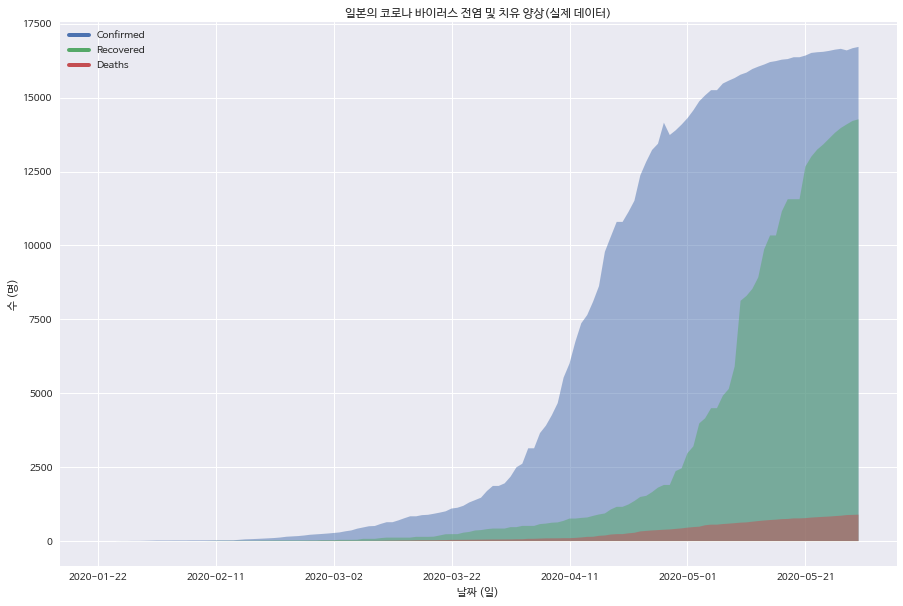

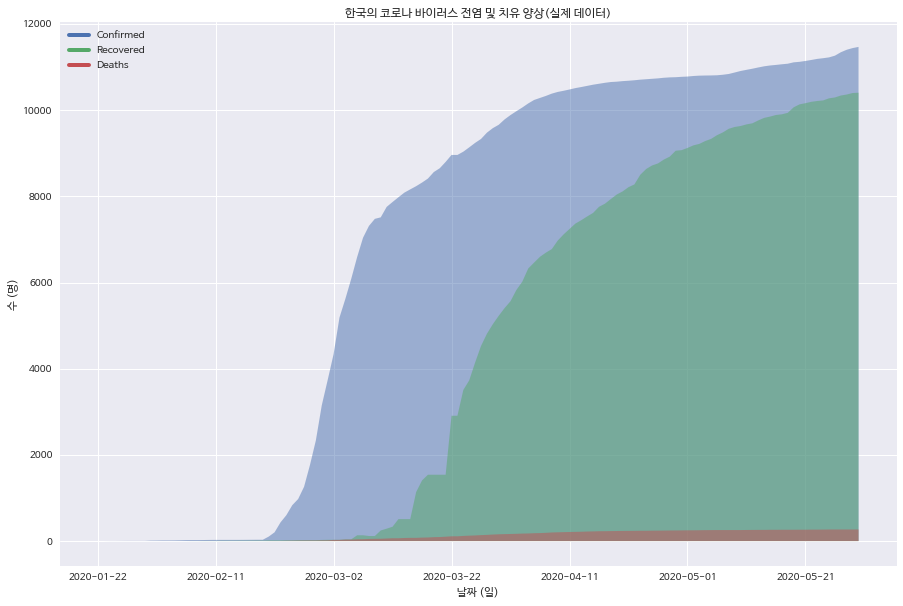

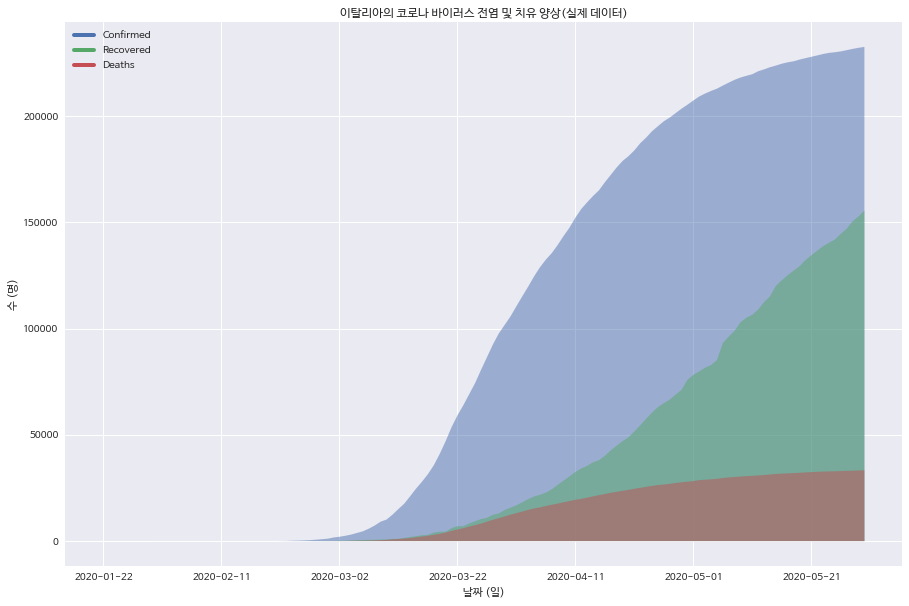

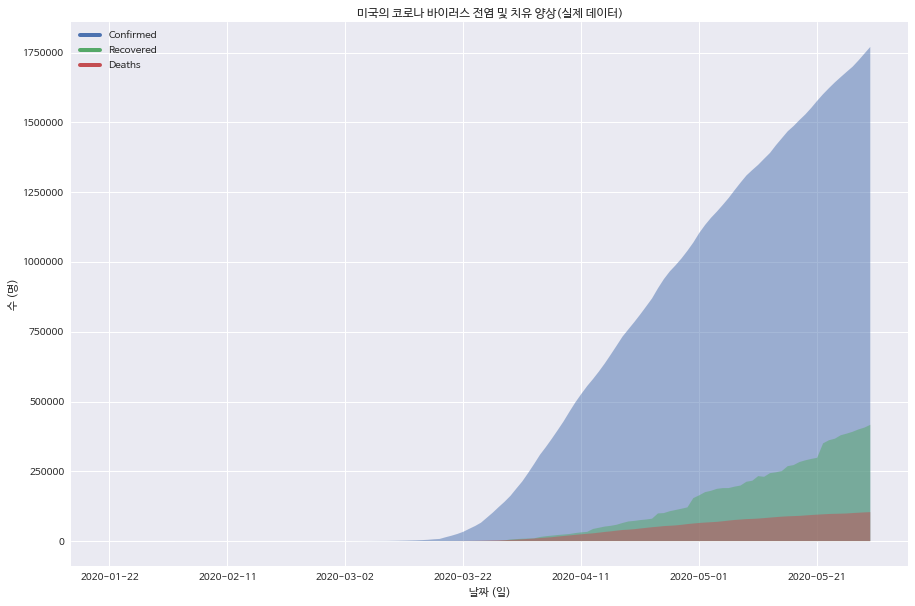

In [7]:
plotCorona(df_japan, '일본')
plotCorona(df_korea, '한국')
plotCorona(df_italy, '이탈리아')
plotCorona(df_us, '미국')

## SEIR Model
#### 시기, 시기에 따라 파라미터 다 다르게 해서 그래프 딱 그리도록 구현하면 좋을텐데 일단 오늘은 사회적 거리두기 전/후만.

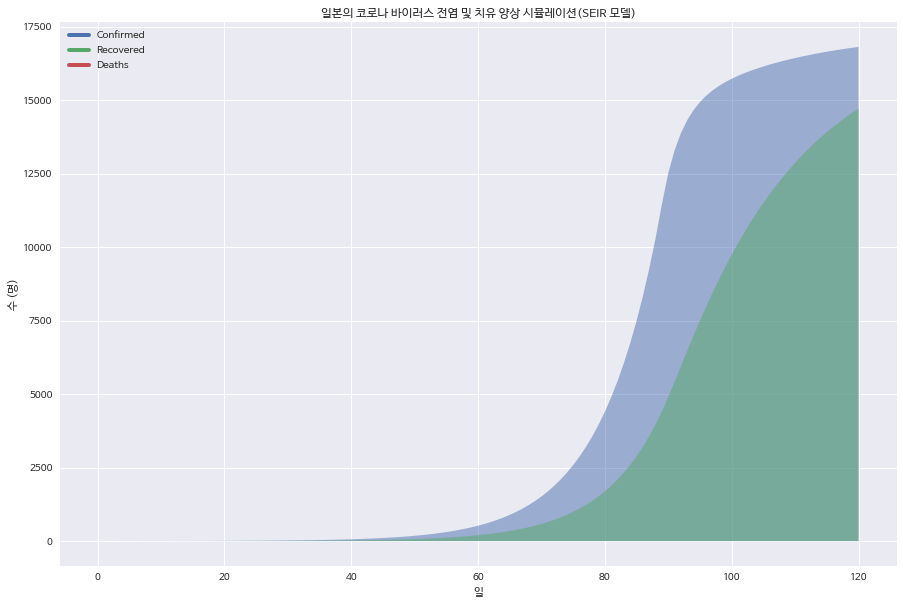

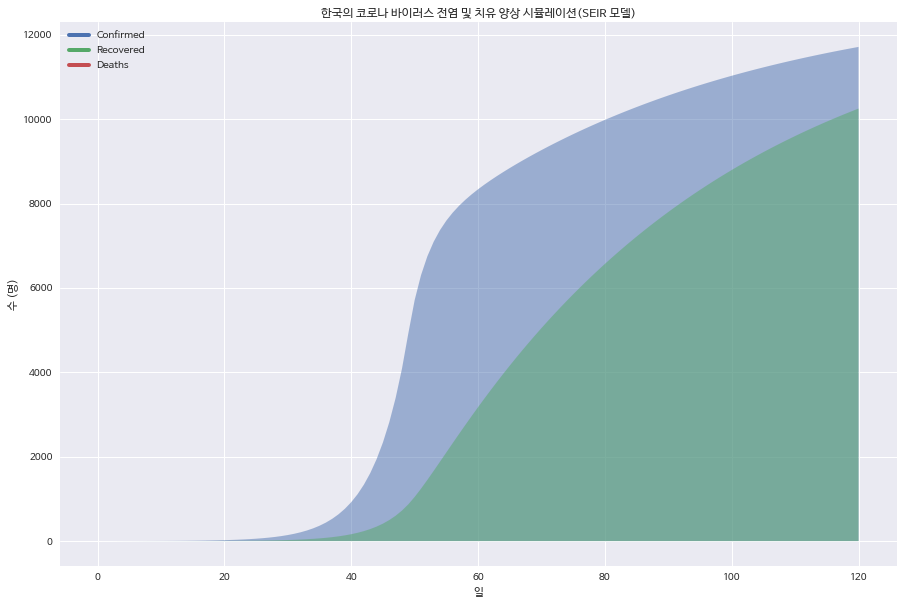

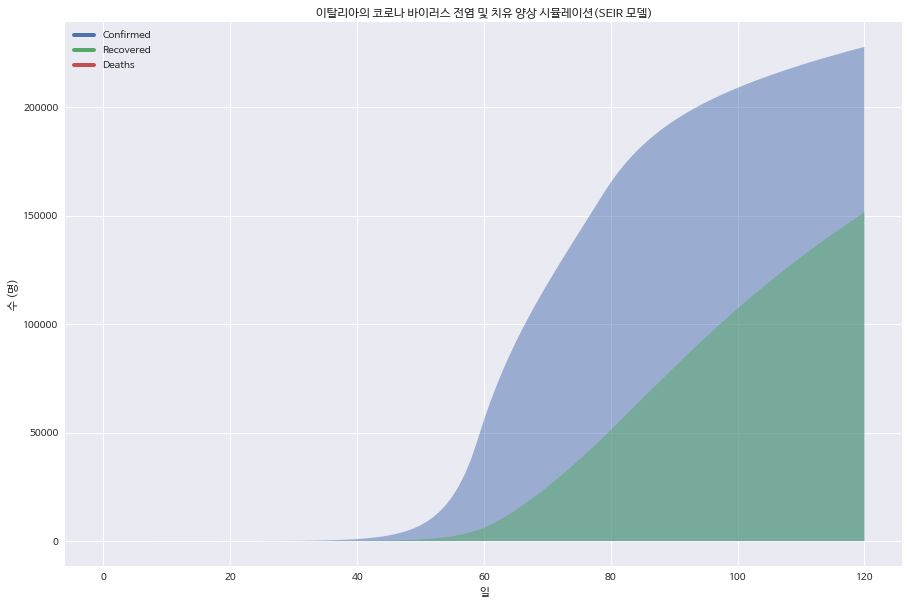

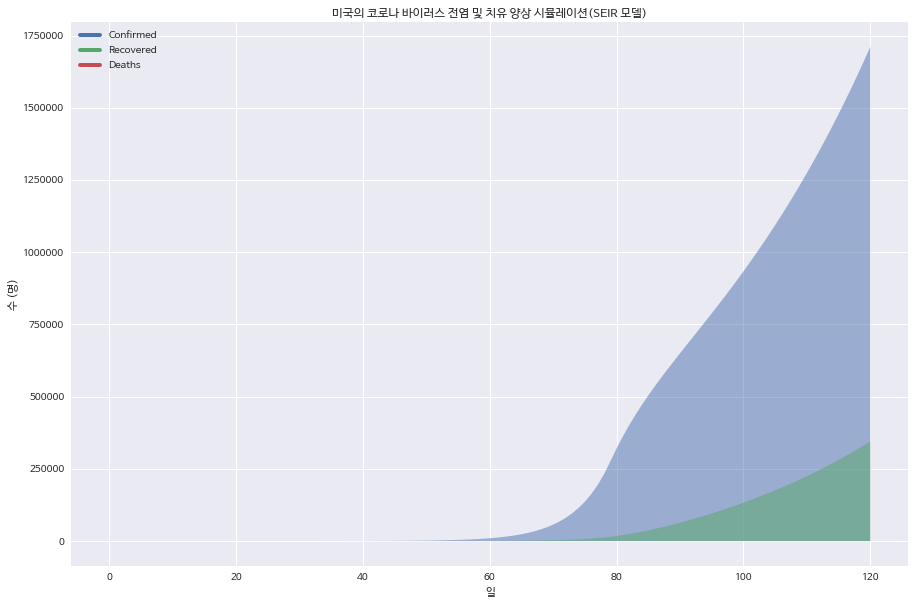

In [8]:
draw_seir(126476261, (1.0/15), (1.0/3), 90, 120, 3.425, 0.95, '일본')
draw_seir(51785790, (1 / 25), (1.0 / 3), 50, 120, 8.8, 0.95, '한국')
draw_seir_2(60461826, (1 / 40), (1.0 / 8.08), 60, 80, 120, 24.6, 0.93, 0.8, '이탈리아')
draw_seir(331002651, (1 / 100), (1.0 / 7.89), 80, 120, 44, 0.9, '미국')

## SEIRD Model

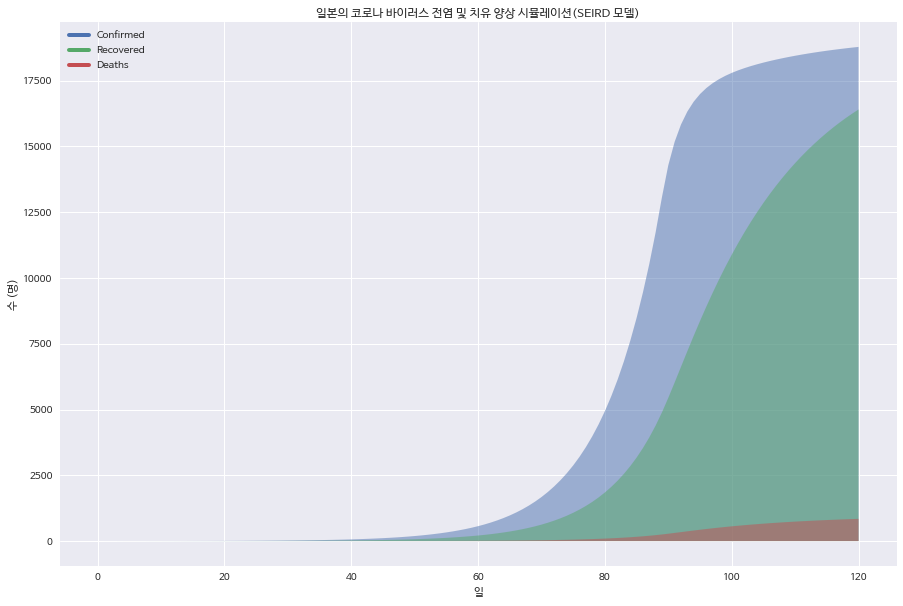

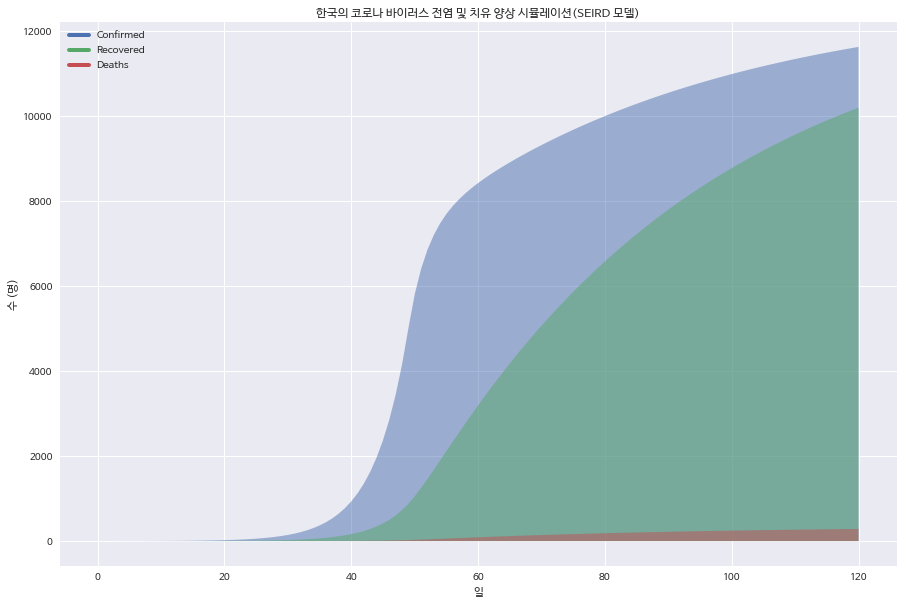

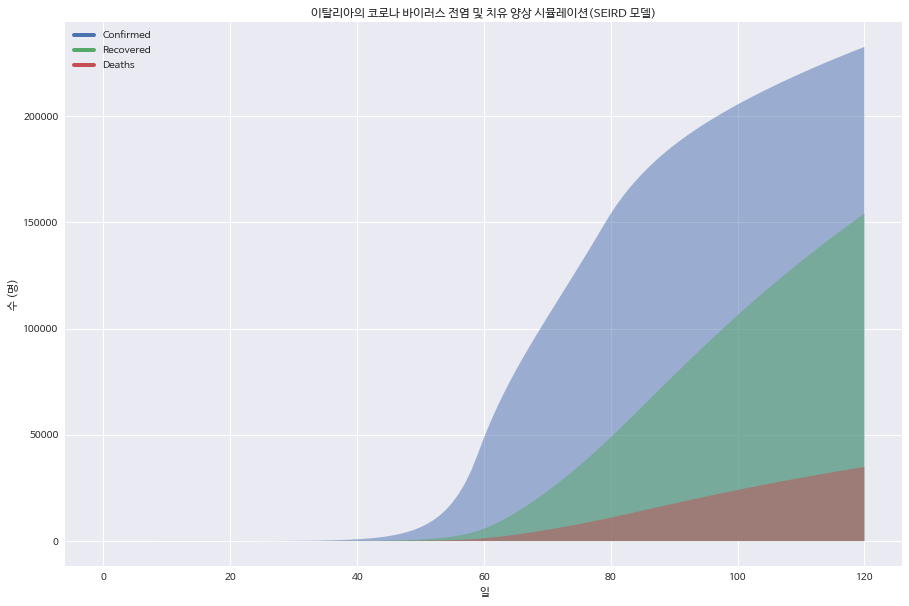

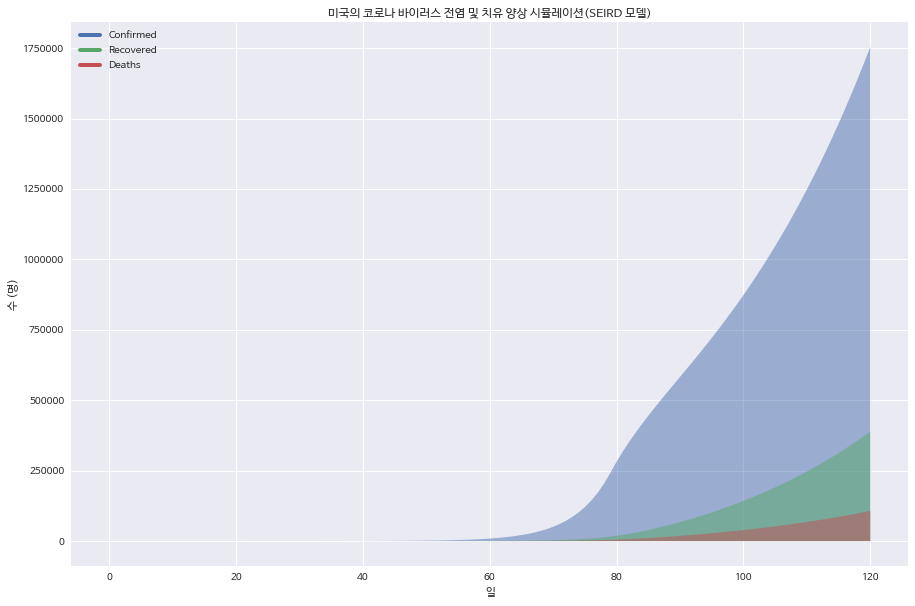

In [9]:
draw_seird(126476261, 0.03, (1.0/15), (1.0/3), (1/9), 90, 120, 3.5, 0.95, '일본')
draw_seird(51785790, 0.01, (1.0/25), (1.0/3), (1/9), 50, 120, 8.85, 0.95, '한국')
draw_seird_2(60461826, 0.055, (1 / 35), (1.0 / 8.08), (1/9), 60, 80, 120, 21.9, 0.9, 0.7, '이탈리아')
draw_seird(331002651, 0.03, (1 / 80), (1.0 / 7.89), (1/9), 80, 120, 35.7, 0.87, '미국')

## SIR Model

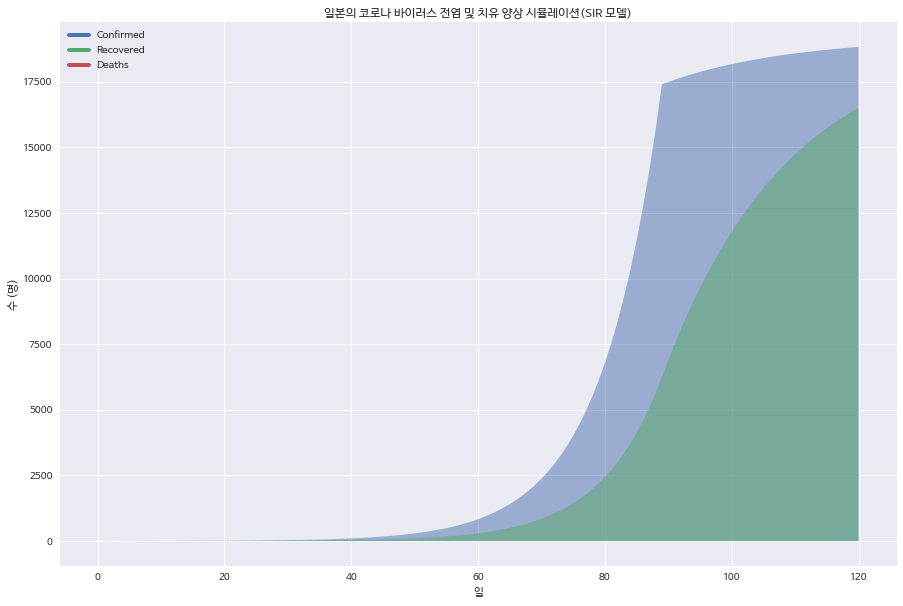

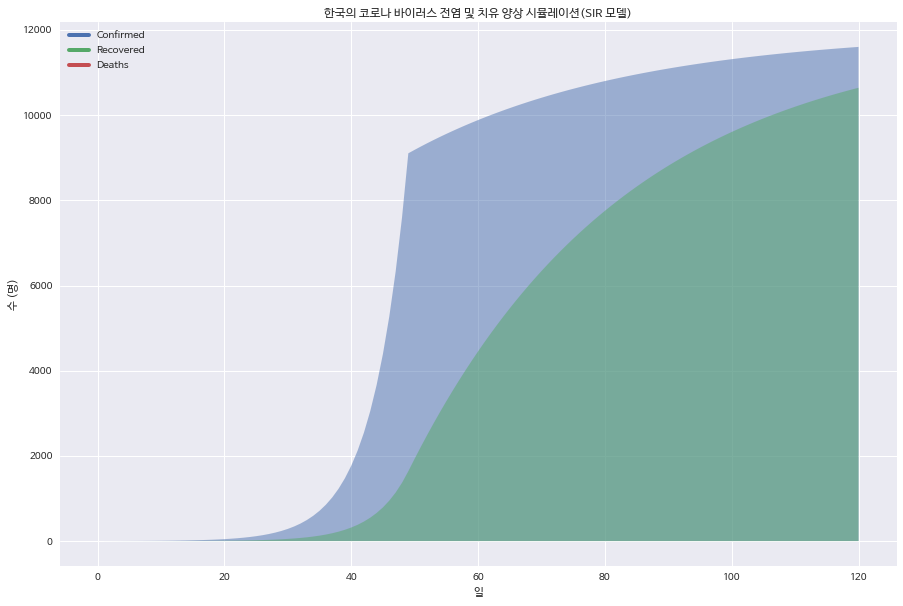

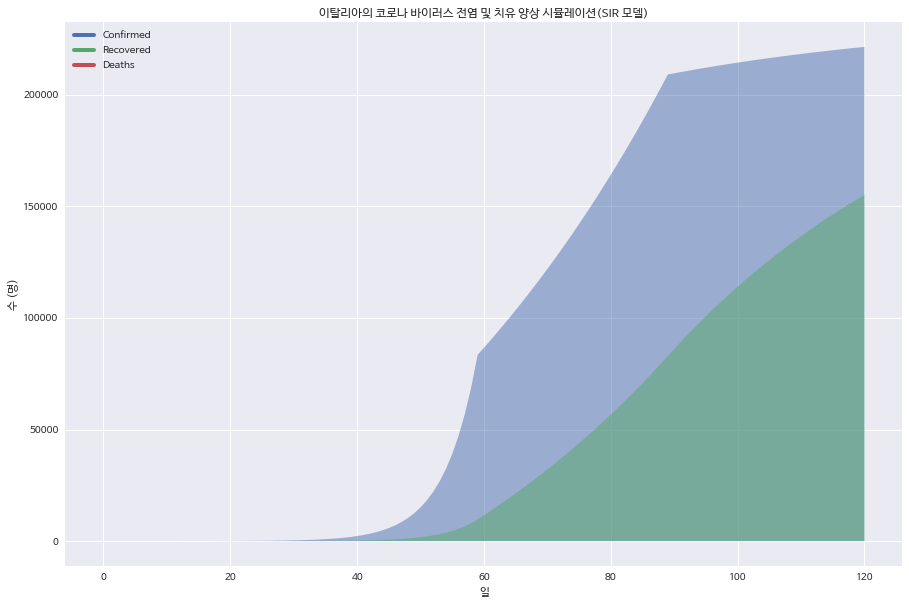

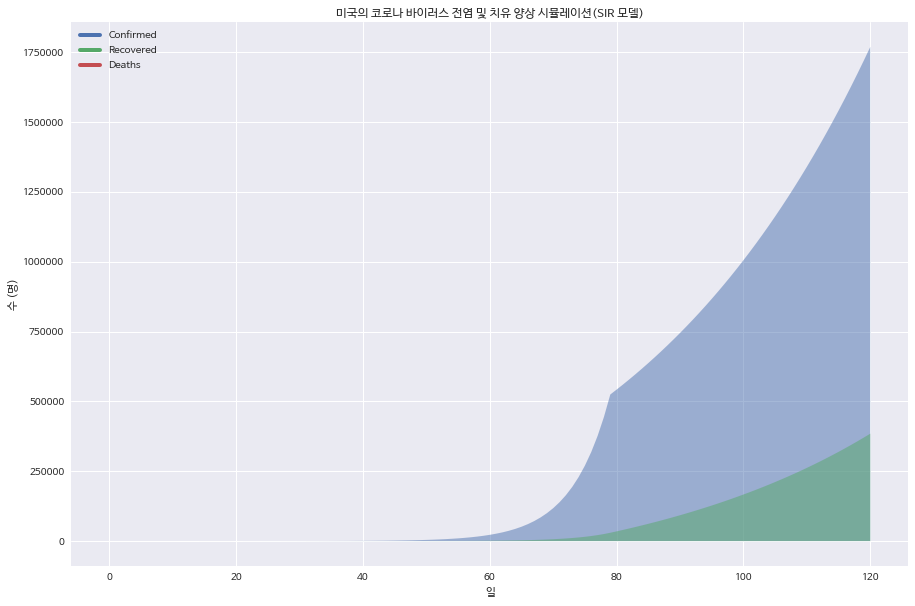

In [10]:
draw_sir(126476261, (1 / 17), (1.0 / 3), 90, 120, 2.78, 0.95, '일본')
draw_sir(51785790, (1 / 25), (1.0 / 3), 50, 120, 5.55, 0.95, '한국')
draw_sir_2(60461826, (1 / 40), (1.0 / 4.01), 60, 90, 120, 8.6, 0.8, 0.9, '이탈리아')
draw_sir(331002651, (1 / 100), (1.0 / 7.89), 80, 120, 17.6, 0.8, '미국')